In [2]:
# prerequisites 
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import pandas as pd

In [3]:
def readDatas(dataPath: str):
    return pd.read_csv(dataPath,delimiter=',', header='infer')

In [5]:
def plotDataDistribution(df_world_happiness):
    fig,axes = plt.subplots(nrows=3,figsize=(15,15))

    axes[0].hist(df_world_happiness["Happiness.Score"])
    axes[0].set_title("Happiness")

    axes[1].hist(df_world_happiness["Economy..GDP.per.Capita."])
    axes[1].set_title("PIB")

    axes[2].hist(df_world_happiness["Freedom"])
    axes[2].set_title("Freedom")
    plt.show()

In [23]:
def plotData(df_world_happiness):
    axes  = plt.figure().add_subplot(projection='3d')

    axes.scatter(df_world_happiness["Economy..GDP.per.Capita."],df_world_happiness["Freedom"],df_world_happiness["Happiness.Score"])
    axes.set_xlabel('GDP')
    axes.set_ylabel('Happiness')
    axes.set_zlabel('Freedom')
    axes.set_title('Relation between GDP and Happiness')
    plt.show()

## Problema 1

In [6]:
world_happiness = readDatas("datas/v1_world-happiness-report-2017.csv")
world_happiness = world_happiness.dropna()

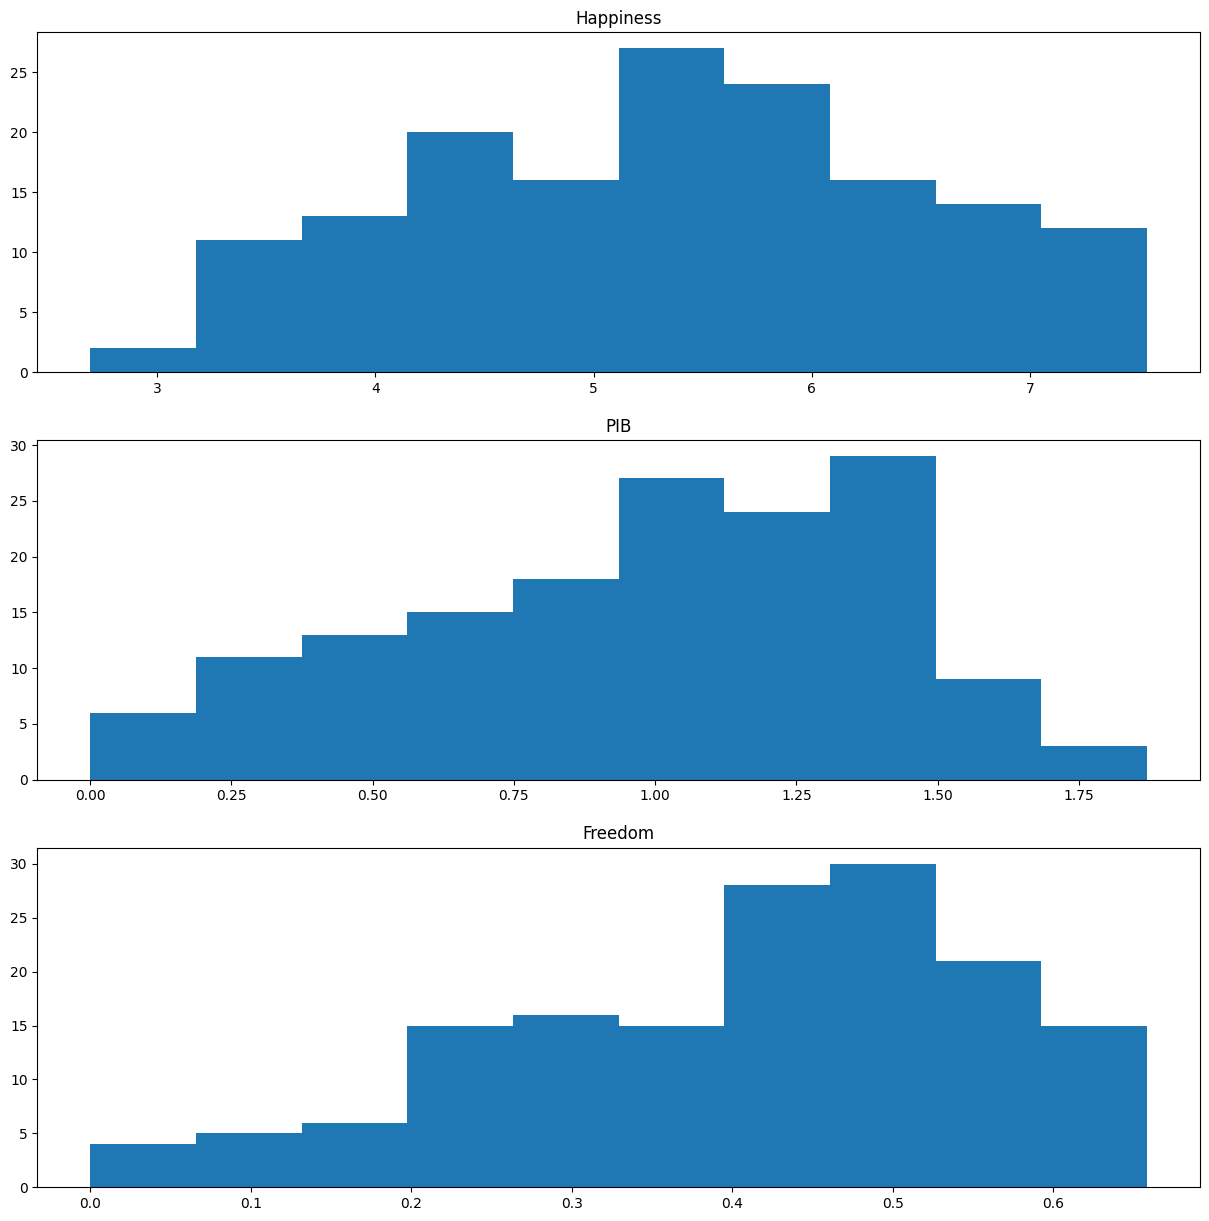

In [7]:
plotDataDistribution(world_happiness)

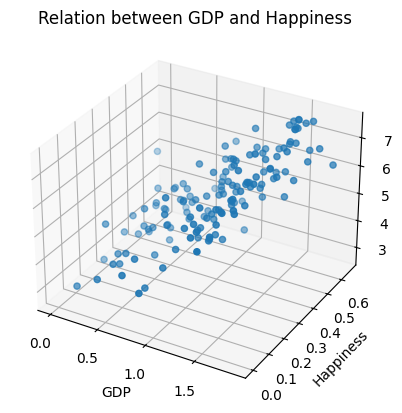

In [24]:
plotData(world_happiness)